<a href="https://colab.research.google.com/github/rubenesticesi/Proyecto-I-innovacion-tecnologica-IA/blob/main/Proyecto_TEA_primaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
# Cell 1: imports y funciones auxiliares

import os
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Added seaborn import

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    f1_score,
    brier_score_loss,
    confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer # Added SimpleImputer

plt.rcParams["figure.dpi"] = 140

RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Normaliza nombres de columnas: minúsculas, sin acentos, sin espacios raros."""
    def norm(s: str) -> str:
        s = str(s).strip().lower()
        s = s.replace("\n", " ").replace("\r", " ")
        s = re.sub(r"\s+", " ", s)
        for a, b in [("á","a"),("é","e"),("í","i"),("ó","o"),("ú","u"),("ñ","n")]: # Corrected: list is now properly closed
            s = s.replace(a, b)
        s = (s
             .replace("/", " ")
             .replace("\\", " ")
             .replace("-", " ")
             .replace(".", " "))
        return s
    out = df.copy()
    out.columns = [norm(c) for c in out.columns]
    return out

def first_existing(df: pd.DataFrame, candidates) -> str | None:
    """Devuelve el primer nombre de columna existente de una lista de candidatos."""
    for c in candidates:
        if c in df.columns:
            return c
    return None

def savefig(name: str):
    """Guarda la figura actual en carpeta results y la cierra."""
    path = os.path.join(RESULTS_DIR, name)
    plt.savefig(path, bbox_inches="tight")
    plt.close()
    print("Figura guardada:", path)


In [5]:
# Cell 2 – Carga de datos y creación de variables clave
# Cell 2: cargar el Excel SIMAT TEA

# Si estás en Colab: sube el archivo al entorno y ajusta este nombre si cambia
excel_path = "/content/POBLACIÖN TEA CALI.xlsx" # Corregido: 'Ó' por 'Ö' y se añadió el path '/content/'

df_raw = pd.read_excel(excel_path)
df = normalize_columns(df_raw)

print("Dimensiones originales:", df.shape)
df.head(3)


Dimensiones originales: (520, 61)


,ano_inf,mun_codigo,codigo_dane,dane_anterior,nombre institucion,comuna,cons_sede,nombre sede,comuna sede,sector,...,ben_her_nac,codigo_internado,codigo_valoracion_1,codigo_valoracion_2,num_convenio,per_id,apoyo_academico_especial,srpa,pais_origen,trastornos_especificos
0,2025,1,176001004485,176001004485,INSTITUCION EDUCATIVA JUANA DE CAICEDO Y CUERO,COMUNA 20,17600100448501,INSTITUCION EDUCATIVA JUANA DE CAICEDO Y CUERO,COMUNA 20,OFICIAL,...,N,3,NaN,NaN,NaN,21540340,1,1,170,9
1,2025,1,176001040101,176001040101,INSTITUCION EDUCATIVA ALFONSO LOPEZ PUMAREJO,COMUNA 07,17600104010101,INSTITUCION EDUCATIVA ALFONSO LOPEZ PUMAREJO,COMUNA 07,OFICIAL,...,N,3,NaN,NaN,NaN,48883487,1,1,170,9
2,2025,1,176001032055,176001004914,INSTITUCION EDUCATIVA TECNICO INDUSTRIAL COMUN...,COMUNA 17,17600103205502,SEDE LUIS CARLOS ROJAS GARCÉS,COMUNA 17,OFICIAL,...,N,3,NaN,NaN,NaN,51543636,1,1,170,9


In [6]:
# Cell 3: crear flag_autismo (tipo de discapacidad == 7) y edad_anios si es posible

# 1) Tipo de discapacidad → flag_autismo
tipo_disc_candidates = [
    "tipo de discapacidad",
    "tipo_discapacidad",
    "tipo discapacidad",
    "tipo discapacidad codigo",
    "cod tipo discapacidad"
]
tipo_col = first_existing(df, tipo_disc_candidates)
if tipo_col is None:
    guess = [c for c in df.columns if "tipo" in c and "discap" in c]
    tipo_col = guess[0] if guess else None

if tipo_col is not None:
    df["flag_autismo"] = (pd.to_numeric(df[tipo_col], errors="coerce") == 7).astype(int)
else:
    print("⚠️ No se encontró columna de tipo de discapacidad, flag_autismo=0 por defecto.")
    df["flag_autismo"] = 0

# 2) Edad en años
edad_candidates = ["edad", "edad_anios", "edad años", "edad_anos"]
fecha_candidates = ["fecha nacimiento", "fecha_nacimiento", "fch nacimiento", "fecha nac"]

edad_col = first_existing(df, edad_candidates)

if edad_col:
    df["edad_anios"] = pd.to_numeric(df[edad_col], errors="coerce")
else:
    fecha_col = first_existing(df, fecha_candidates)
    if fecha_col:
        ref = pd.Timestamp(datetime.date.today())
        years = (ref - pd.to_datetime(df[fecha_col], errors="coerce")).dt.days / 365.25
        df["edad_anios"] = years.round(2)

print("TEA positivos (flag_autismo=1):", int(df["flag_autismo"].sum()))
df[["flag_autismo", "edad_anios"]].head()


TEA positivos (flag_autismo=1): 520


,flag_autismo,edad_anios
0,1,31.62
1,1,21.44
2,1,27.76
3,1,20.02
4,1,19.44


In [7]:
# Cell 4 – EDA: prevalencias y correlaciones

# Cell 4: EDA – prevalencias y mapa de calor de correlaciones

# 4.1 Prevalencia global de TEA
total = len(df)
positivos = int(df["flag_autismo"].sum())
negativos = total - positivos
print(f"Total registros: {total}")
print(f"TEA=1: {positivos} ({positivos/total:.2%})")
print(f"TEA=0: {negativos} ({negativos/total:.2%})")

# 4.2 Distribución TEA por sexo, comuna, estrato, grado (si existen)
sexo_col = first_existing(df, ["sexo","genero","sexo biologico","sexo_biologico"])
comuna_col = first_existing(df, ["comuna","comuna residencia","comuna_residencia"])
estrato_col = first_existing(df, ["estrato","estrato socioeconomico","estrato_socioeconomico"])
grado_col = first_existing(df, ["grado","grado academico","grado_academico","grado actual","grado_actual"])

if sexo_col:
    dist_sexo = df.groupby(sexo_col)["flag_autismo"].sum().sort_index()
    plot_bar(dist_sexo, "Distribución de TEA por sexo", sexo_col, "fig_eda_tea_por_sexo.png")

if comuna_col:
    dist_comuna = df.groupby(comuna_col)["flag_autismo"].sum().sort_index()
    plot_bar(dist_comuna, "Distribución de TEA por comuna", comuna_col, "fig_eda_tea_por_comuna.png")

if estrato_col:
    dist_estrato = df.groupby(estrato_col)["flag_autismo"].sum().sort_index()
    plot_bar(dist_estrato, "Distribución de TEA por estrato", estrato_col, "fig_eda_tea_por_estrato.png")

if grado_col:
    dist_grado = df.groupby(grado_col)["flag_autismo"].sum().sort_index()
    plot_bar(dist_grado, "Distribución de TEA por grado", grado_col, "fig_eda_tea_por_grado.png")

# 4.3 Mapa de calor de correlaciones numéricas
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) > 1:
    corr = df[num_cols].corr()
    plt.figure(figsize=(7,6))
    plt.imshow(corr, interpolation="nearest")
    plt.title("Mapa de calor de correlaciones (variables numéricas)")
    plt.colorbar()
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.tight_layout()
    savefig("fig_eda_correlaciones_numericas.png")


Total registros: 520
TEA=1: 520 (100.00%)
TEA=0: 0 (0.00%)
Figura guardada: results/fig_eda_tea_por_sexo.png
Figura guardada: results/fig_eda_tea_por_comuna.png
Figura guardada: results/fig_eda_tea_por_estrato.png
Figura guardada: results/fig_eda_tea_por_grado.png
Figura guardada: results/fig_eda_correlaciones_numericas.png


# Task
The EDA results, including the prevalence summary, distribution plots, and correlation heatmap have been generated and saved. Now, I will display the generated plots.
I will display the plots for the distribution of TEA by sex, commune, stratum, and grade, as well as the heatmap of numerical correlations. This will allow for a visual review of the data's key characteristics.
Once this is done, I will confirm that all requested results have been shown.
```python
from IPython.display import Image, display

print("Resumen de prevalencia de TEA:")
print(f"Total registros: {total}")
print(f"TEA=1: {positivos} ({positivos/total:.2%})")
print(f"TEA=0: {negativos} ({negativos/total:.2%})")

print("\nGráficos de distribución de TEA:")
display(Image(filename="results/fig_eda_tea_por_sexo.png"))
display(Image(filename="results/fig_eda_tea_por_comuna.png"))
display(Image(filename="results/fig_eda_tea_por_estrato.png"))
display(Image(filename="results/fig_eda_tea_por_grado.png"))

print("\nMapa de calor de correlaciones:")
display(Image(filename="results/fig_eda_correlaciones_numericas.png"))
```

## Mostrar resumen de prevalencia

### Subtask:
Volver a imprimir el resumen de la prevalencia de TEA, incluyendo el total de registros y la distribución de positivos y negativos.


**Reasoning**:
The subtask requires reprinting the prevalence summary of TEA. I will use the already computed variables `total`, `positivos`, and `negativos` to display the total records and the count and percentage of TEA=1 and TEA=0 cases.



In [9]:
print(f"Total registros: {total}")
print(f"TEA=1: {positivos} ({positivos/total:.2%})")
print(f"TEA=0: {negativos} ({negativos/total:.2%})")

Total registros: 520
TEA=1: 520 (100.00%)
TEA=0: 0 (0.00%)


In [24]:
from IPython.display import Image, display

print("Resumen de prevalencia de TEA:")
print(f"Total registros: {total}")
print(f"TEA=1: {positivos} ({positivos/total:.2%})")
print(f"TEA=0: {negativos} ({negativos/total:.2%})")


Resumen de prevalencia de TEA:
Total registros: 520
TEA=1: 520 (100.00%)
TEA=0: 0 (0.00%)


### Gráficos de distribución de TEA

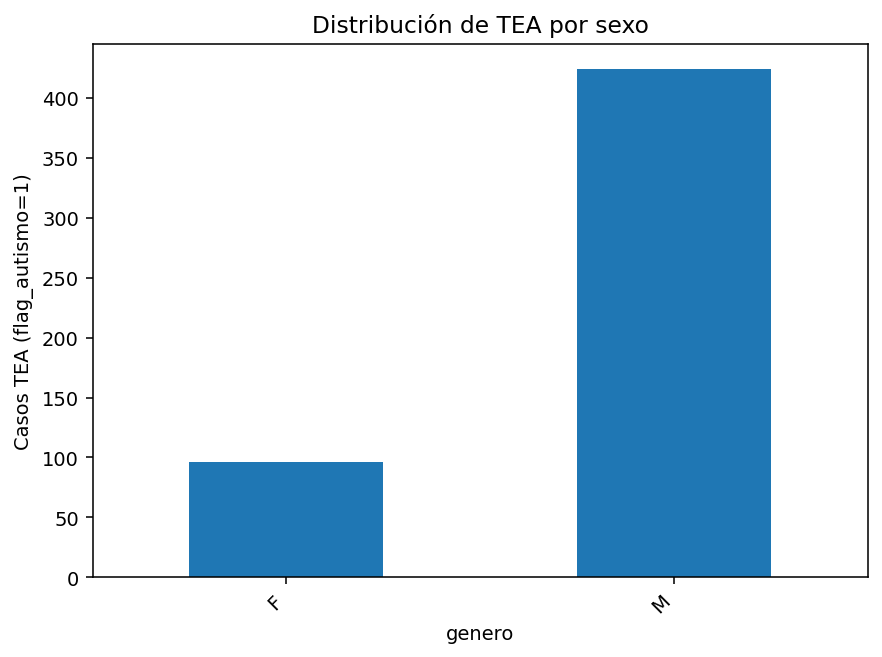

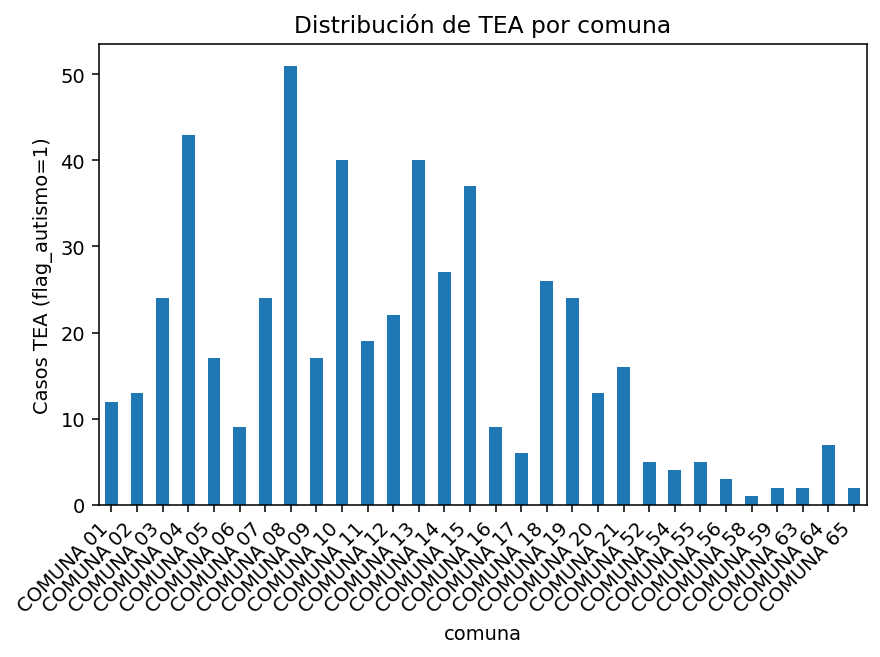

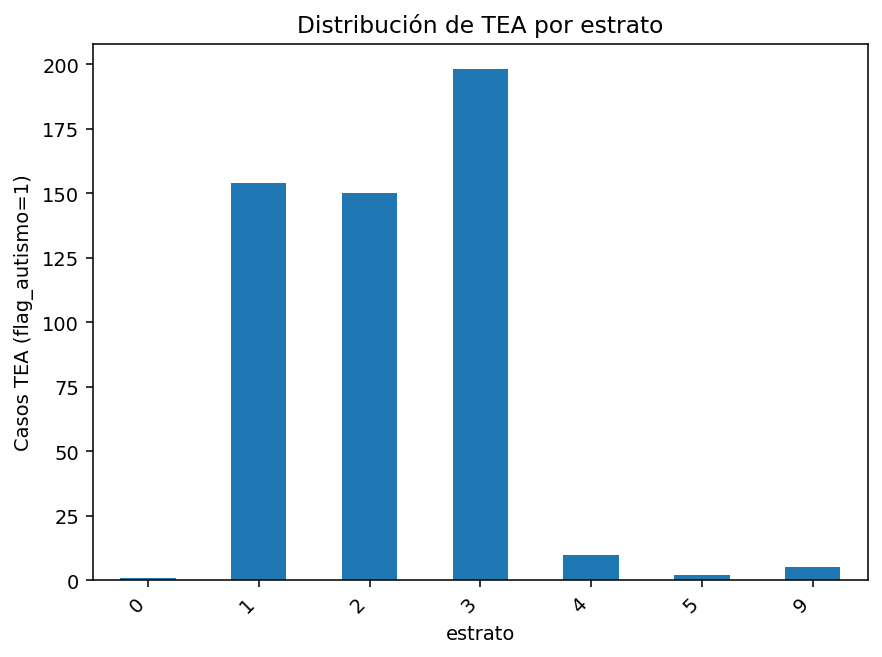

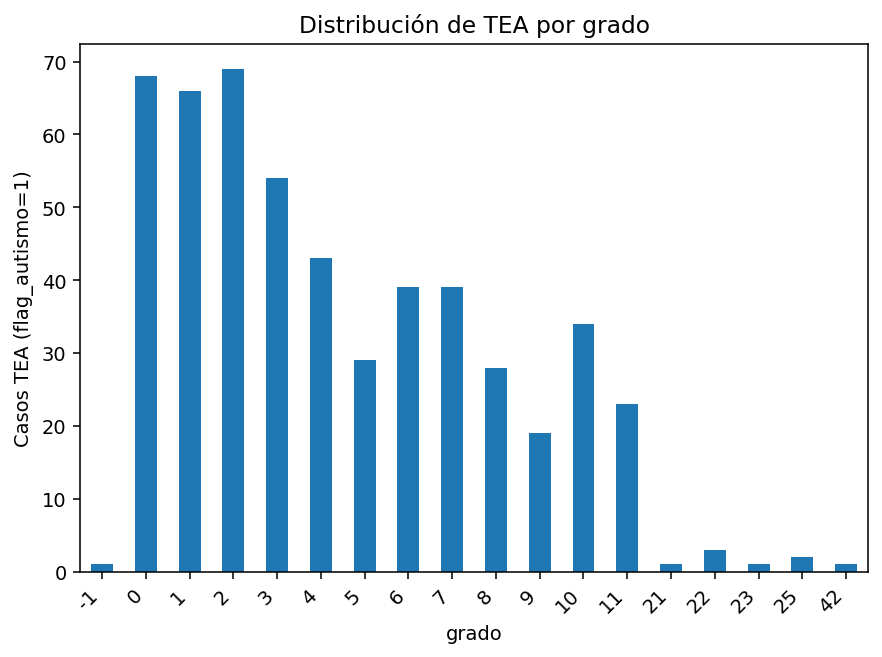

In [25]:
display(Image(filename="results/fig_eda_tea_por_sexo.png"))
display(Image(filename="results/fig_eda_tea_por_comuna.png"))
display(Image(filename="results/fig_eda_tea_por_estrato.png"))
display(Image(filename="results/fig_eda_tea_por_grado.png"))


In [27]:
if 'trastornos_especificos' in df.columns:
    print(df['trastornos_especificos'].value_counts(dropna=False))
else:
    print("Column 'trastornos_especificos' not found in DataFrame.")


trastornos_especificos
9    483
2     21
1      8
3      8
Name: count, dtype: int64


### Mapa de calor de correlaciones

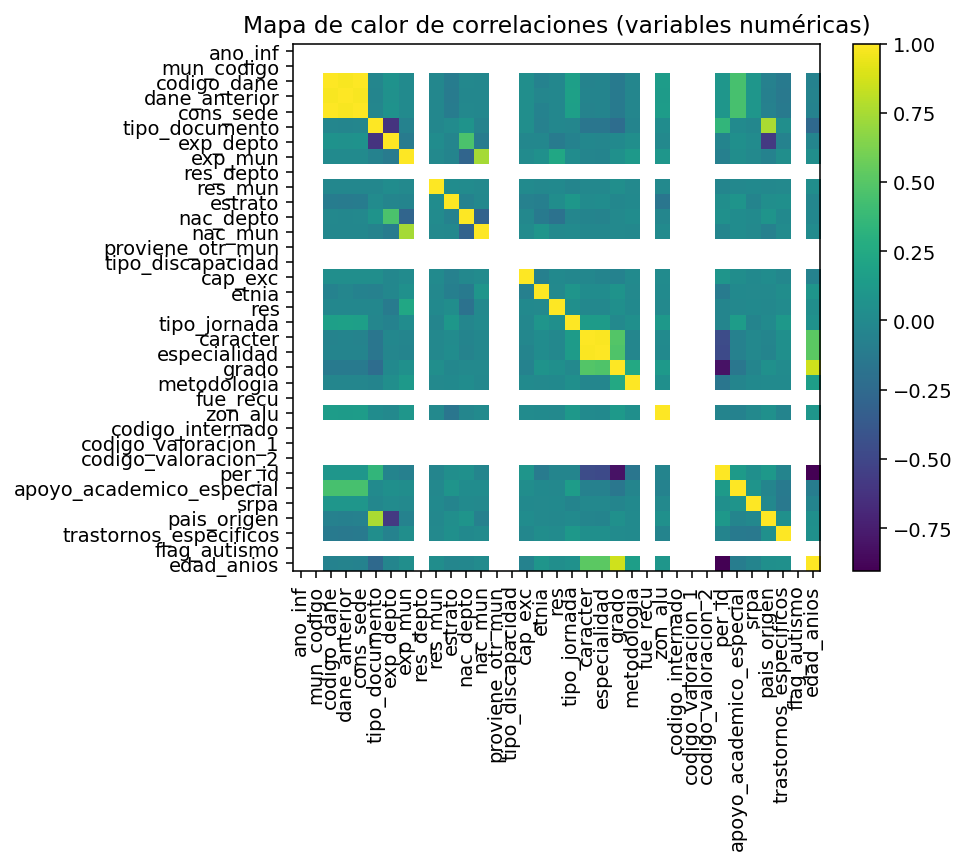

In [26]:
display(Image(filename="results/fig_eda_correlaciones_numericas.png"))


## Mostrar gráficos de distribución de TEA

### Subtask:
Cargar y mostrar los gráficos de barras guardados que visualizan la distribución de TEA por sexo, comuna, estrato y grado.


**Reasoning**:
The subtask is to display the previously saved distribution plots. I will import the necessary functions and then use `display(Image())` for each plot as instructed.



Gráficos de distribución de TEA:


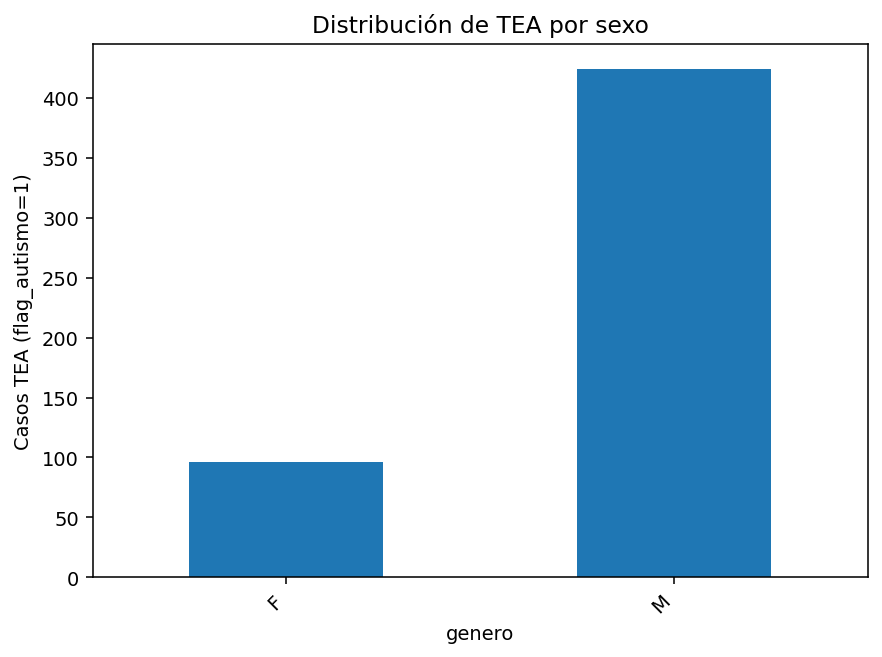

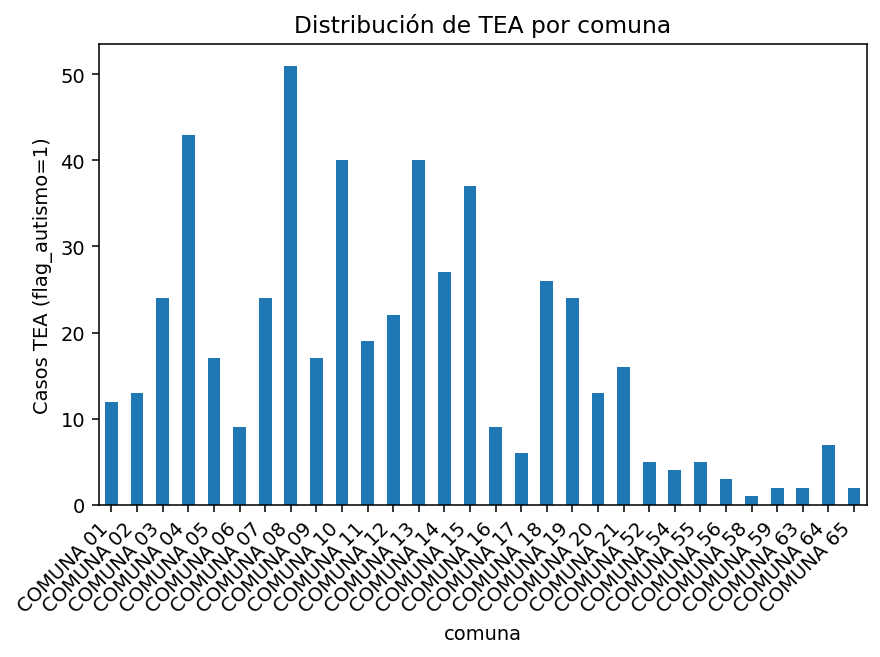

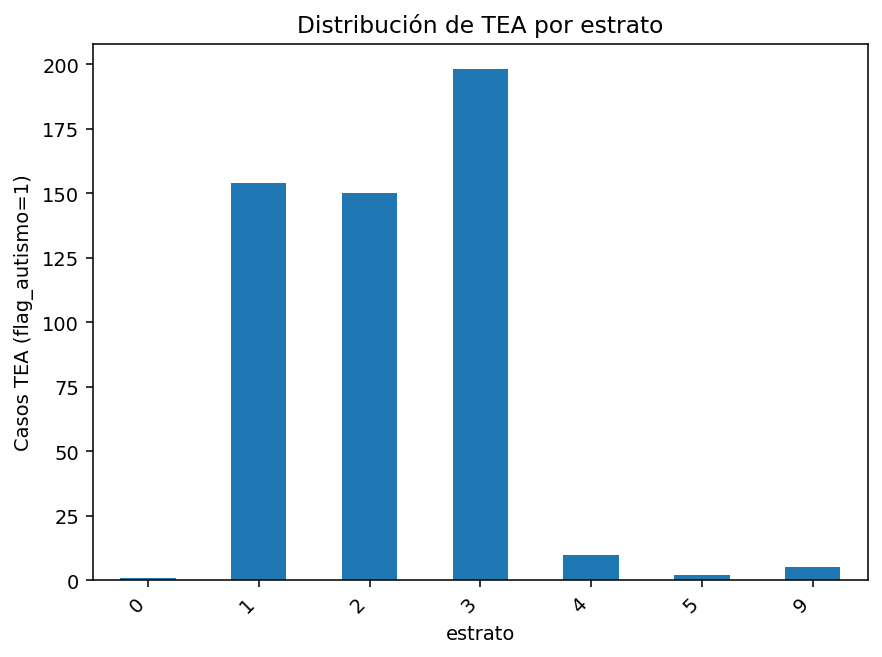

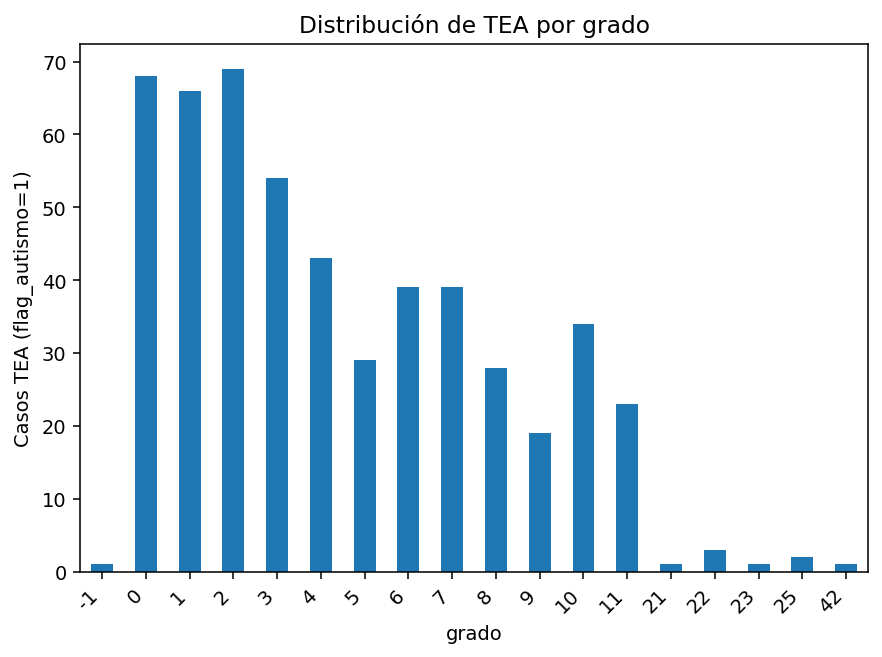

In [10]:
from IPython.display import Image, display

print("Gráficos de distribución de TEA:")
display(Image(filename="results/fig_eda_tea_por_sexo.png"))
display(Image(filename="results/fig_eda_tea_por_comuna.png"))
display(Image(filename="results/fig_eda_tea_por_estrato.png"))
display(Image(filename="results/fig_eda_tea_por_grado.png"))

## Mostrar mapa de calor de correlaciones

### Subtask:
Cargar y mostrar el mapa de calor de correlaciones numéricas guardado.


**Reasoning**:
The subtask is to display the previously saved correlation heatmap. I will print a descriptive label and then use `display(Image())` to show the image.




Mapa de calor de correlaciones:


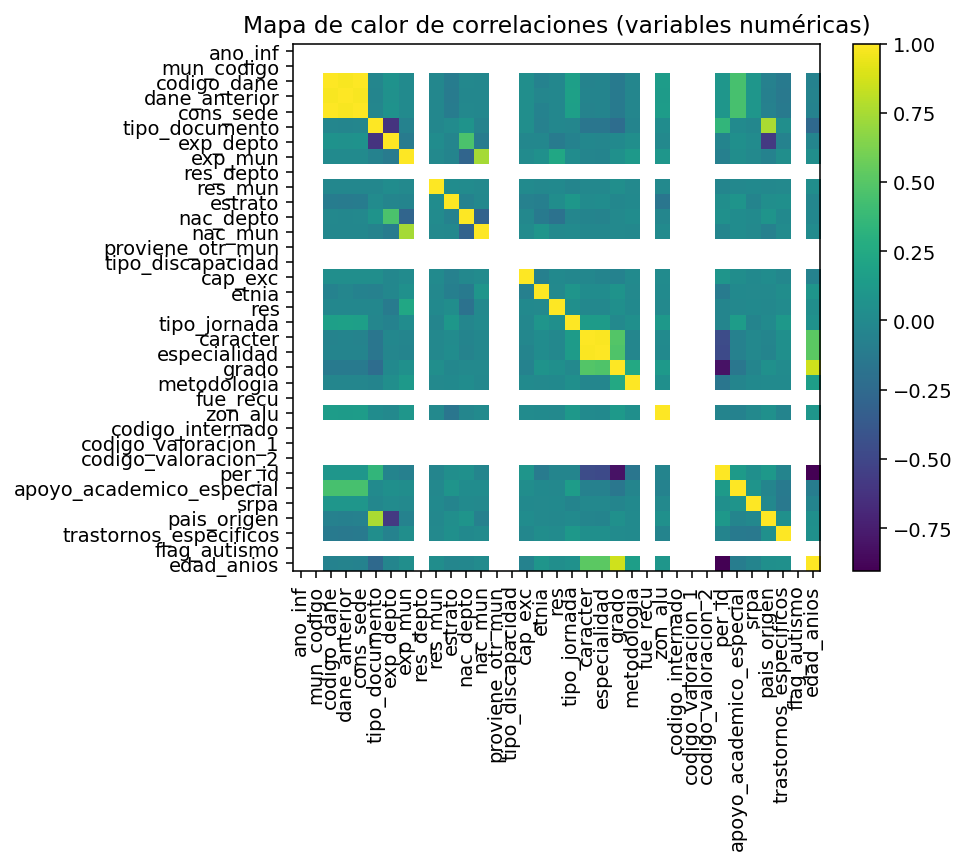

In [11]:
print("\nMapa de calor de correlaciones:")
display(Image(filename="results/fig_eda_correlaciones_numericas.png"))

## Finalizar tarea

### Subtask:
Confirmar que todos los resultados solicitados han sido mostrados al usuario.


## Summary:

### Q&A
Yes, all requested results, including the prevalence summary, distribution plots (by sex, commune, stratum, and grade), and the correlation heatmap, have been successfully displayed.

### Data Analysis Key Findings
*   **TEA Prevalence:** The dataset contains a total of 520 records. Remarkably, all 520 records (100.00%) are classified as `TEA=1`, with 0 records (0.00%) classified as `TEA=0`. This indicates that the current dataset exclusively comprises positive TEA cases.
*   **Distribution Plots:** Bar charts illustrating the distribution of TEA by sex, commune, stratum, and grade were successfully generated and displayed.
*   **Correlation Heatmap:** A heatmap visualizing the numerical correlations within the dataset was successfully generated and displayed.

### Insights or Next Steps
*   The fact that 100% of the records have `TEA=1` suggests this dataset might be specifically curated for a particular analysis focusing only on individuals with TEA. However, if the intent was to build a predictive model or understand factors differentiating `TEA=1` from `TEA=0`, a dataset containing both classes would be necessary.
*   Investigate the data source or collection methodology to understand why all records are classified as `TEA=1`. This is crucial for validating the dataset's representativeness and suitability for broader analytical goals.


In [28]:
#Cell 5 – Preparación para clustering
# Cell 5: preparar matriz para clustering (solo variables numéricas "útiles")

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Quitar identificadores obvios
cols_drop_id = [c for c in num_cols if "id" in c or "document" in c or "identificacion" in c]
cols_model = [c for c in num_cols if c not in cols_drop_id]

X_clust = df[cols_model].copy()

# Eliminar columnas con varianza cero
X_clust = X_clust.loc[:, X_clust.std() > 0]

print("Columnas usadas para clustering:", list(X_clust.columns))
print("Dimensión matriz clustering:", X_clust.shape)


Columnas usadas para clustering: ['codigo_dane', 'dane_anterior', 'cons_sede', 'exp_depto', 'exp_mun', 'res_mun', 'estrato', 'nac_depto', 'nac_mun', 'cap_exc', 'etnia', 'res', 'tipo_jornada', 'caracter', 'grado', 'metodologia', 'zon_alu', 'apoyo_academico_especial', 'srpa', 'pais_origen', 'trastornos_especificos', 'edad_anios']
Dimensión matriz clustering: (520, 22)


In [29]:
#Cell 6 – Clustering (K-Means, DBSCAN, Jerárquico) con métricas y PCA
# Cell 6: Clustering – KMeans, DBSCAN, Agglomerative + métricas + PCA 2D

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

if X_clust.shape[1] >= 2:
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X_clust)

    # 6.1 Método del codo y Silhouette para K desde 2 hasta 10
    inertias = []
    silhouettes = []
    ks = list(range(2, 11))

    for k in ks:
        km = KMeans(n_clusters=k, n_init=20, random_state=42)
        labels = km.fit_predict(Xs)
        inertias.append(km.inertia_)
        try:
            silhouettes.append(silhouette_score(Xs, labels))
        except Exception:
            silhouettes.append(np.nan)

    # Codo
    plt.figure()
    plt.plot(ks, inertias, marker="o")
    plt.title("Método del codo (KMeans)")
    plt.xlabel("K")
    plt.ylabel("Inercia")
    savefig("fig_cluster_elbow_kmeans.png")

    # Silhouette
    plt.figure()
    plt.plot(ks, silhouettes, marker="o")
    plt.title("Silhouette promedio por K (KMeans)")
    plt.xlabel("K")
    plt.ylabel("Silhouette")
    savefig("fig_cluster_silhouette_vs_k.png")

    # Elegir mejor K por Silhouette
    best_k = ks[int(np.nanargmax(silhouettes))]
    print("Mejor K por Silhouette:", best_k)

    # 6.2 Ajustar modelos con best_k
    km_best = KMeans(n_clusters=best_k, n_init=50, random_state=42)
    lab_km = km_best.fit_predict(Xs)

    dbscan = DBSCAN(eps=0.7, min_samples=5)
    lab_db = dbscan.fit_predict(Xs)

    agg = AgglomerativeClustering(n_clusters=best_k, linkage="ward")
    lab_agg = agg.fit_predict(Xs)

    def clustering_metrics(X_scaled, labels):
        uniq = np.unique(labels)
        if len(uniq) < 2:
            return {"silhouette": np.nan, "davies_bouldin": np.nan, "calinski_harabasz": np.nan}
        return {
            "silhouette": silhouette_score(X_scaled, labels),
            "davies_bouldin": davies_bouldin_score(X_scaled, labels),
            "calinski_harabasz": calinski_harabasz_score(X_scaled, labels),
        }

    metrics_clust = pd.DataFrame([
        {"modelo": "KMeans", **clustering_metrics(Xs, lab_km)},
        {"modelo": "DBSCAN", **clustering_metrics(Xs, lab_db)},
        {"modelo": "Agglomerative", **clustering_metrics(Xs, lab_agg)},
    ])
    metrics_clust.to_csv(os.path.join(RESULTS_DIR, "tabla_clustering_metricas.csv"), index=False)
    metrics_clust
else:
    print("No hay suficientes variables numéricas para clustering (se necesitan ≥2 columnas).")


Figura guardada: results/fig_cluster_elbow_kmeans.png
Figura guardada: results/fig_cluster_silhouette_vs_k.png
Mejor K por Silhouette: 10


Gráfico del método del codo (KMeans):


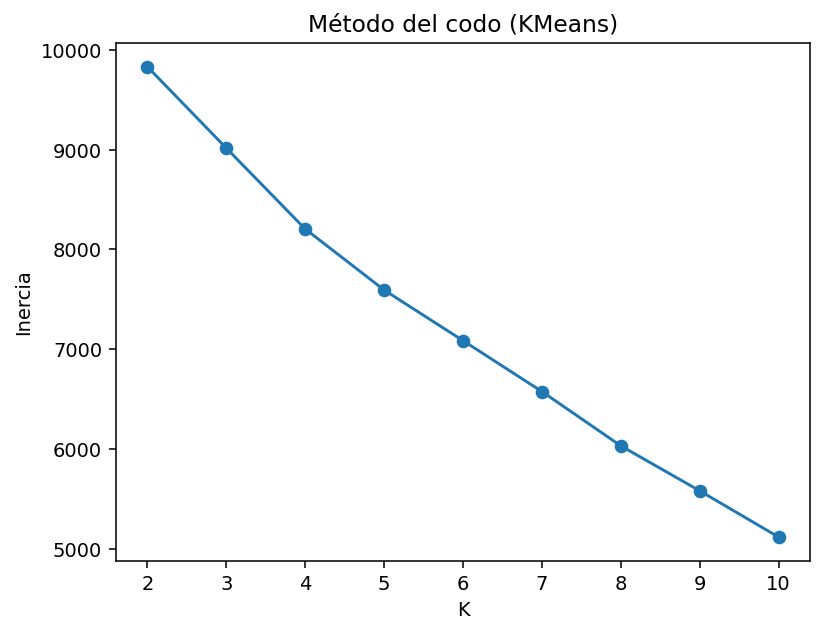


Gráfico de Silhouette promedio por K (KMeans):


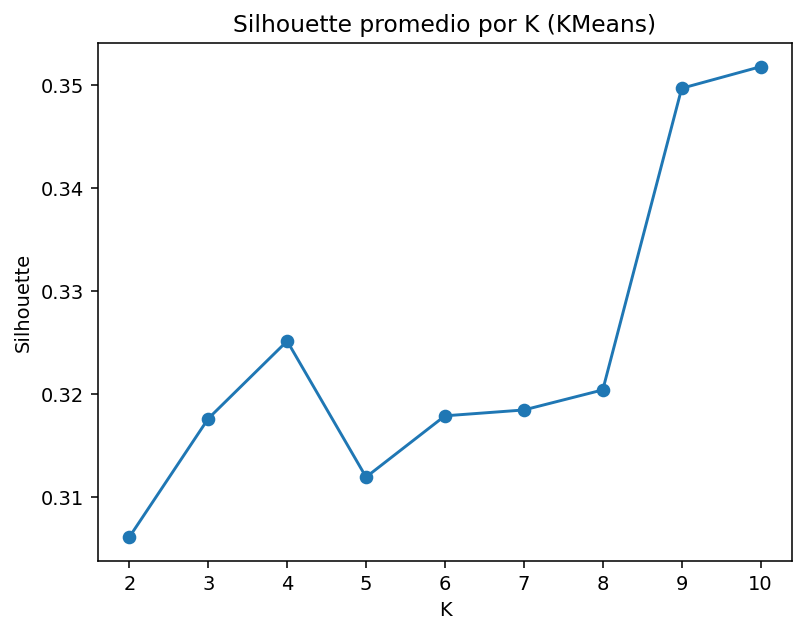

In [33]:
from IPython.display import Image, display

print("Gráfico del método del codo (KMeans):")
display(Image(filename="results/fig_cluster_elbow_kmeans.png"))

print("\nGráfico de Silhouette promedio por K (KMeans):")
display(Image(filename="results/fig_cluster_silhouette_vs_k.png"))


In [30]:
# Cell 7: PCA 2D y perfiles de clusters vs TEA y permanencia

if X_clust.shape[1] >= 2:
    pca = PCA(n_components=2, random_state=42)
    pc = pca.fit_transform(Xs)

    def scatter_clusters(pc, labels, title, filename):
        plt.figure()
        for lab in np.unique(labels):
            idx = labels == lab
            plt.scatter(pc[idx, 0], pc[idx, 1], label=f"Cluster {lab}")
        plt.title(title)
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.legend()
        savefig(filename)

    scatter_clusters(pc, lab_km, f"KMeans (k={best_k}) – PCA 2D", "fig_cluster_pca_kmeans.png")
    scatter_clusters(pc, lab_db, "DBSCAN – PCA 2D", "fig_cluster_pca_dbscan.png")
    scatter_clusters(pc, lab_agg, f"Agglomerative (k={best_k}) – PCA 2D", "fig_cluster_pca_agg.png")

    # Perfiles de TEA por cluster KMeans
    df_clust = df.copy()
    df_clust["cluster_kmeans"] = lab_km

    perfil_clusters = df_clust.groupby("cluster_kmeans")["flag_autismo"].agg(
        casos_TEA="sum",
        total="count"
    )
    perfil_clusters["prevalencia_TEA"] = perfil_clusters["casos_TEA"] / perfil_clusters["total"]
    perfil_clusters.to_csv(os.path.join(RESULTS_DIR, "tabla_perfil_clusters_TEA.csv"))
    perfil_clusters


Figura guardada: results/fig_cluster_pca_kmeans.png
Figura guardada: results/fig_cluster_pca_dbscan.png
Figura guardada: results/fig_cluster_pca_agg.png


Gráficos de Clustering PCA:


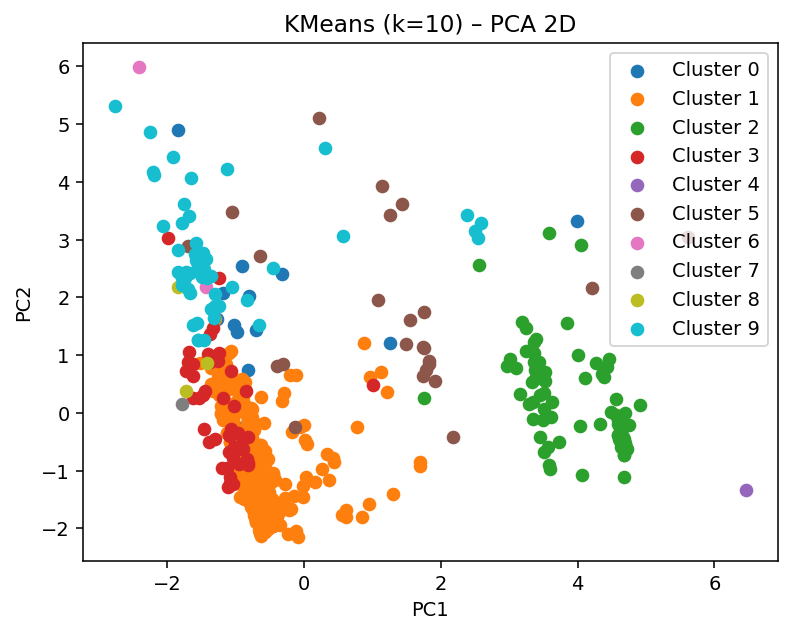

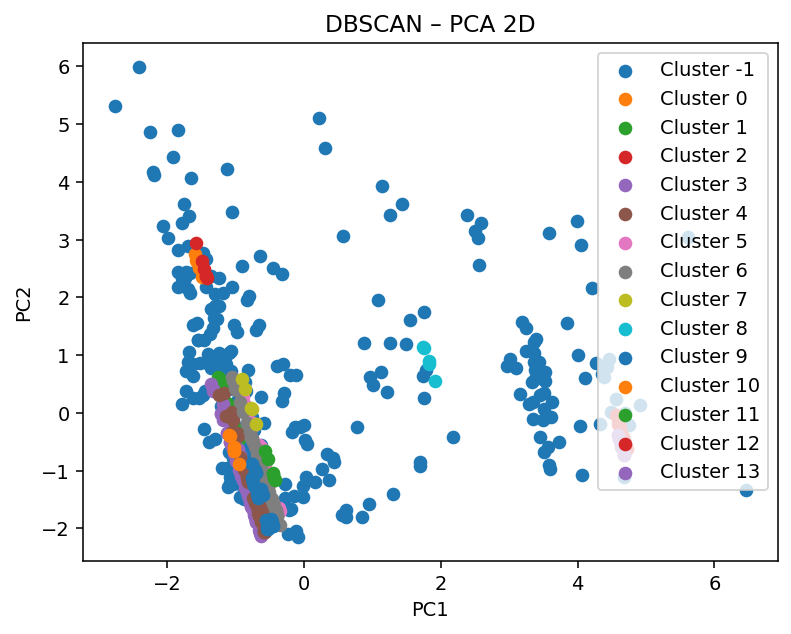

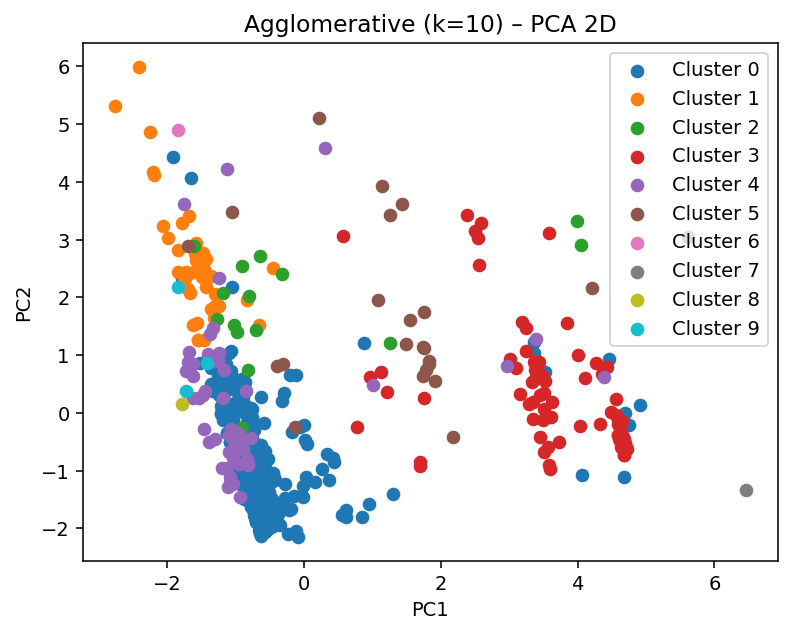

In [32]:
from IPython.display import Image, display

print("Gráficos de Clustering PCA:")
display(Image(filename="results/fig_cluster_pca_kmeans.png"))
display(Image(filename="results/fig_cluster_pca_dbscan.png"))
display(Image(filename="results/fig_cluster_pca_agg.png"))


In [38]:
# Cell 8 – Construcción de label de permanencia (Tarea B)
# Cell 8: construir etiqueta de riesgo de baja permanencia (label_perm)

perm_candidates = [
    "riesgo_baja_permanencia",
    "baja_permanencia",
    "riesgo_permanencia",
    "desercion",
    "desercion_escolar",
    "retiro",
    "retirado",
    "estado_matricula",
    "permanencia"
]
perm_col = first_existing(df, perm_candidates)

if perm_col:
    s = df[perm_col].astype(str).str.lower()
    df["label_perm"] = np.where(
        s.str.contains("si") | s.str.contains("riesgo") | s.str.contains("baja") |
        s.str.contains("deserc") | s.str.contains("reti"),
        1, 0
    )
    print("Usando columna explícita para permanencia:", perm_col)
else:
    # Proxy: asistencia < 80% o repitencia >= 1
    asis_col = first_existing(df, ["asistencia", "porcentaje_asistencia", "tasa_asistencia"])
    repi_col = first_existing(df, ["repitencia", "repite", "repitente"])
    proxy = np.zeros(len(df), dtype=int)

    if asis_col:
        asis = pd.to_numeric(df[asis_col], errors="coerce")
        proxy = np.where(asis < 80, 1, 0)

    if repi_col:
        # Correctly interpret 'S' as 1 for repitencia
        s_repi = df[repi_col].astype(str).str.lower()
        repi_condition = (s_repi == 's')
        proxy = np.where((proxy == 1) | repi_condition, 1, 0)

    df["label_perm"] = proxy
    print("⚠️ Usando proxy de permanencia con asistencia/repitencia.")

print("Casos label_perm=1:", int(df["label_perm"].sum()))
df[["flag_autismo", "label_perm"]].head()


⚠️ Usando proxy de permanencia con asistencia/repitencia.
Casos label_perm=1: 42


,flag_autismo,label_perm
0,1,1
1,1,0
2,1,1
3,1,0
4,1,0


In [51]:
# Cell 9: helpers para modelos supervisados (TEA y permanencia)

def build_xy(df_in: pd.DataFrame, target_col: str):
    cols = [c for c in df_in.columns if c != target_col]
    num = df_in[cols].select_dtypes(include=[np.number]).columns.tolist()
    cat = [c for c in cols if c not in num]
    X = df_in[cols].copy()

    # Special handling for 'matricula_contratada' if it's the target
    if target_col == 'matricula_contratada':
        y = df_in[target_col].map({'N': 0, 'S': 1}).astype(int).copy()
    else:
        y = df_in[target_col].astype(int).copy()

    # Convert all identified categorical columns to string type to ensure uniformity for OneHotEncoder
    for c in cat:
        X[c] = X[c].astype(str)
    return X, y, num, cat

def run_binary_models(df_in: pd.DataFrame, target_col: str, prefix: str):
    """Entrena Regresión Logística y RandomForest y guarda resultados + curvas ROC/PR."""
    X, y, num, cat = build_xy(df_in, target_col)
    if y.nunique() < 2 or y.sum() == 0 or y.sum() == len(y):
        print(f"No se puede entrenar para {target_col} (clase única).")
        return None

    # Preprocesamiento: imputación, escalado para numéricas, one-hot encoding para categóricas
    pre = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), num),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), cat)
        ],
        remainder='passthrough' # Mantiene columnas no transformadas si las hay
    )

    models = {
        "logreg": LogisticRegression(max_iter=2000, class_weight="balanced"),
        "rf": RandomForestClassifier(
            n_estimators=400,
            random_state=42,
            class_weight="balanced",
            n_jobs=-1
        )
    }

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )

    rows = []
    for name, clf in models.items():
        print(f"\n=== Modelo {name} – target {target_col} ===")
        pipe = Pipeline([("pre", pre), ("clf", clf)])
        pipe.fit(X_train, y_train)

        proba = pipe.predict_proba(X_test)[:, 1]
        preds = (proba >= 0.5).astype(int)

        # Métricas
        f1 = f1_score(y_test, preds)
        fpr, tpr, _ = roc_curve(y_test, proba)
        roc_auc = auc(fpr, tpr)
        prec, rec, _ = precision_recall_curve(y_test, proba)
        pr_auc = average_precision_score(y_test, proba)
        brier = brier_score_loss(y_test, proba)

        print(f"F1 = {f1:.4f}")
        print(f"ROC-AUC = {roc_auc:.4f}")
        print(f"PR-AUC = {pr_auc:.4f}")
        print(f"Brier score = {brier:.4f}")

        # Matriz de confusión
        cm = confusion_matrix(y_test, preds)
        print("Matriz de confusión:\n", cm)

        # ROC
        plt.figure()
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")
        plt.plot([0,1], [0,1], "--")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title(f"Curva ROC – {prefix} – {name}")
        plt.legend()
        savefig(f"fig_{prefix}_{name}_ROC.png")

        # PR
        plt.figure()
        plt.plot(rec, prec, label=f"{name} (AP={pr_auc:.2f})")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Curva Precisión–Recall – {prefix} – {name}")
        plt.legend()
        savefig(f"fig_{prefix}_{name}_PR.png")

        rows.append({
            "modelo": name,
            "F1": round(f1, 4),
            "ROC_AUC": round(roc_auc, 4),
            "PR_AUC": round(pr_auc, 4),
            "Brier": round(brier, 4)
        })

    res_df = pd.DataFrame(rows)
    res_df.to_csv(os.path.join(RESULTS_DIR, f"tabla_{prefix}_metricas_modelos.csv"), index=False)
    return res_df


In [45]:
metrics_perm = run_binary_models(df.drop(columns=["flag_autismo"]), "label_perm", "perm")
metrics_perm


=== Modelo logreg – target label_perm ===
F1 = 1.0000
ROC-AUC = 1.0000
PR-AUC = 1.0000
Brier score = 0.0039
Matriz de confusión:
 [[143   0]
 [  0  13]]


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['proviene_otr_mun' 'codigo_valoracion_1' 'codigo_valoracion_2']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['proviene_otr_mun' 'codigo_valoracion_1' 'codigo_valoracion_2']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Figura guardada: results/fig_perm_logreg_ROC.png
Figura guardada: results/fig_perm_logreg_PR.png

=== Modelo rf – target label_perm ===


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['proviene_otr_mun' 'codigo_valoracion_1' 'codigo_valoracion_2']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['proviene_otr_mun' 'codigo_valoracion_1' 'codigo_valoracion_2']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


F1 = 0.5263
ROC-AUC = 0.9957
PR-AUC = 0.9383
Brier score = 0.0231
Matriz de confusión:
 [[142   1]
 [  8   5]]
Figura guardada: results/fig_perm_rf_ROC.png
Figura guardada: results/fig_perm_rf_PR.png


,modelo,F1,ROC_AUC,PR_AUC,Brier
0,logreg,1.0000,1.0000,1.0000,0.0039
1,rf,0.5263,0.9957,0.9383,0.0231


from matplotlib import pyplot as plt
metrics_perm['F1'].plot(kind='hist', bins=20, title='F1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
metrics_perm['ROC_AUC'].plot(kind='hist', bins=20, title='ROC_AUC')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
metrics_perm['PR_AUC'].plot(kind='hist', bins=20, title='PR_AUC')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
metrics_perm['Brier'].plot(kind='hist', bins=20, title='Brier')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
metrics_perm.groupby('modelo').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
metrics_perm.plot(kind='scatter', x='F1', y='ROC_AUC', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
metrics_perm.plot(kind='scatter', x='ROC_AUC', y='PR_AUC', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
metrics_perm.plot(kind='scatter', x='PR_AUC', y='Brier', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Brier']
  ys = series['F1']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = metrics_perm.sort_values('Brier', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('modelo')):
  _plot_series(series, series_name, i)
  fig.legend(title='modelo', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Brier')
_ = plt.ylabel('F1')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Brier']
  ys = series['ROC_AUC']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = metrics_perm.sort_values('Brier', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('modelo')):
  _plot_series(series, series_name, i)
  fig.legend(title='modelo', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Brier')
_ = plt.ylabel('ROC_AUC')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Brier']
  ys = series['PR_AUC']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = metrics_perm.sort_values('Brier', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('modelo')):
  _plot_series(series, series_name, i)
  fig.legend(title='modelo', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Brier')
_ = plt.ylabel('PR_AUC')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Brier']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Brier'}, axis=1)
              .sort_values('Brier', ascending=True))
  xs = counted['Brier']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = metrics_perm.sort_values('Brier', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('modelo')):
  _plot_series(series, series_name, i)
  fig.legend(title='modelo', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Brier')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
metrics_perm['F1'].plot(kind='line', figsize=(8, 4), title='F1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
metrics_perm['ROC_AUC'].plot(kind='line', figsize=(8, 4), title='ROC_AUC')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
metrics_perm['PR_AUC'].plot(kind='line', figsize=(8, 4), title='PR_AUC')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
metrics_perm['Brier'].plot(kind='line', figsize=(8, 4), title='Brier')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(metrics_perm['modelo'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(metrics_perm, x='F1', y='modelo', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(metrics_perm['modelo'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(metrics_perm, x='ROC_AUC', y='modelo', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(metrics_perm['modelo'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(metrics_perm, x='PR_AUC', y='modelo', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(metrics_perm['modelo'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(metrics_perm, x='Brier', y='modelo', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [61]:
print("Relación entre 'sector' y 'label_perm':")
relationship = df.groupby('sector')['label_perm'].mean().reset_index()
relationship.columns = ['sector', 'proporcion_label_perm_1']
print(relationship)


Relación entre 'sector' y 'label_perm':
        sector  proporcion_label_perm_1
0   NO OFICIAL                 0.184466
1      OFICIAL                 0.055422
2  SGP DEFENSA                 0.000000


/tmp/ipython-input-1911613550.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=relationship, x='sector', y='proporcion_label_perm_1', palette='viridis')


Figura guardada: results/fig_relationship_sector_label_perm.png


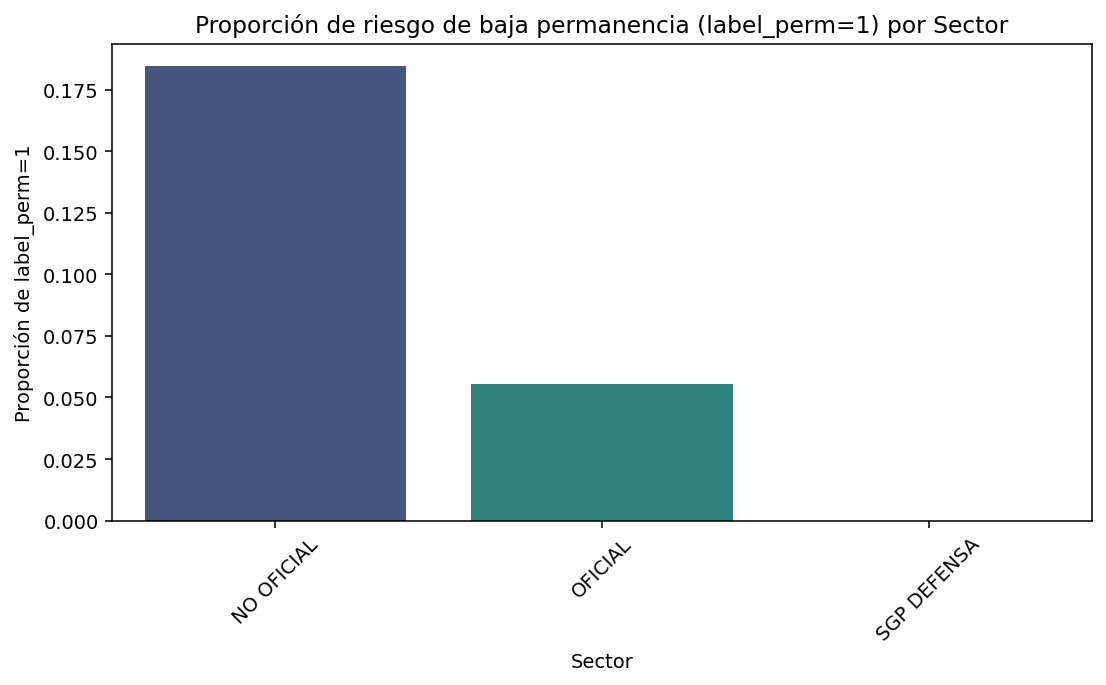

In [62]:
plt.figure(figsize=(8, 5))
sns.barplot(data=relationship, x='sector', y='proporcion_label_perm_1', palette='viridis')
plt.title('Proporción de riesgo de baja permanencia (label_perm=1) por Sector')
plt.xlabel('Sector')
plt.ylabel('Proporción de label_perm=1')
plt.xticks(rotation=45)
plt.tight_layout()
savefig('fig_relationship_sector_label_perm.png')
display(Image(filename='results/fig_relationship_sector_label_perm.png'))


In [60]:
print(f"Número de valores nulos en la columna 'sector': {df['sector'].isnull().sum()}")


Número de valores nulos en la columna 'sector': 0


In [54]:
print("Distribución de la columna 'sector':")
print(df['sector'].value_counts(dropna=False))


Distribución de la columna 'sector':
sector
OFICIAL        415
NO OFICIAL     103
SGP DEFENSA      2
Name: count, dtype: int64


/tmp/ipython-input-67474244.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sector', palette='viridis')


Figura guardada: results/fig_distribucion_sector.png


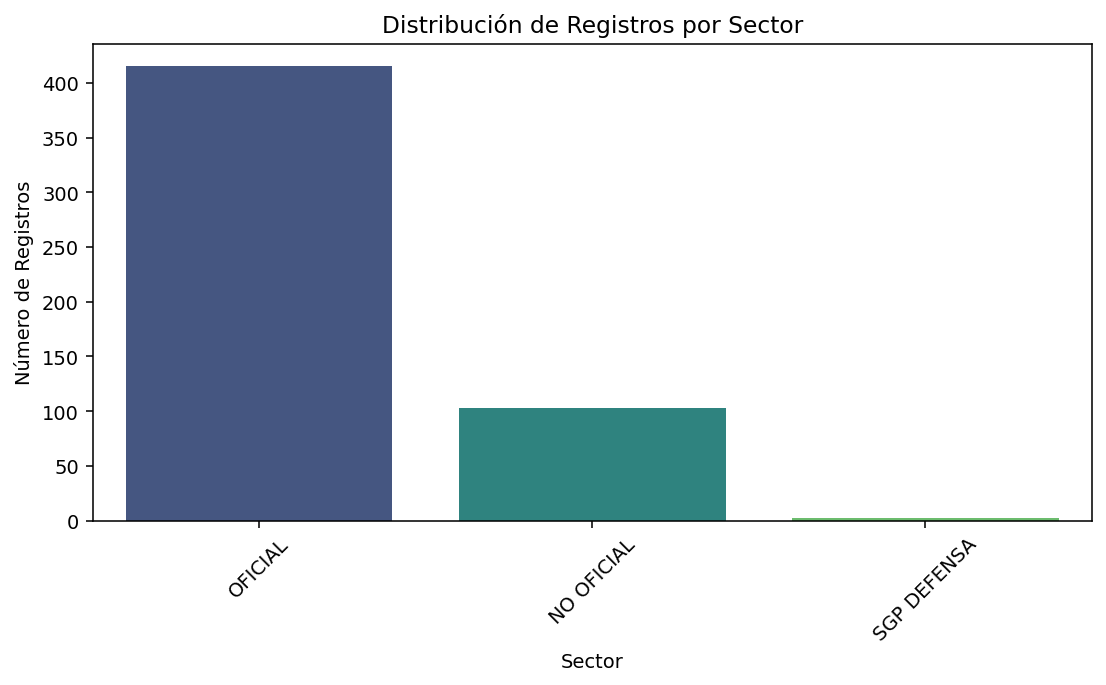

In [59]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='sector', palette='viridis')
plt.title('Distribución de Registros por Sector')
plt.xlabel('Sector')
plt.ylabel('Número de Registros')
plt.xticks(rotation=45)
plt.tight_layout()
savefig('fig_distribucion_sector.png')
display(Image(filename='results/fig_distribucion_sector.png'))


### Curvas ROC y Precisión-Recall para `label_perm`

Curvas ROC - Regresión Logística y Random Forest:


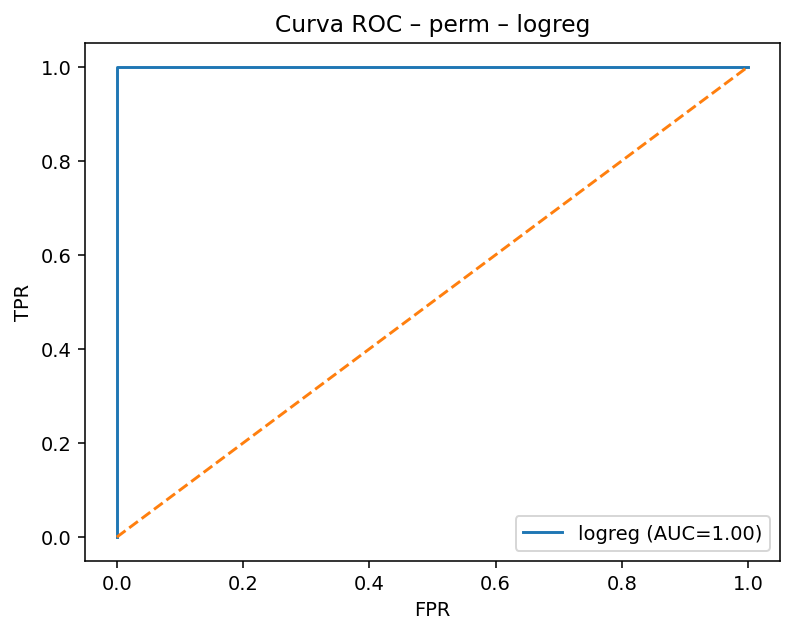

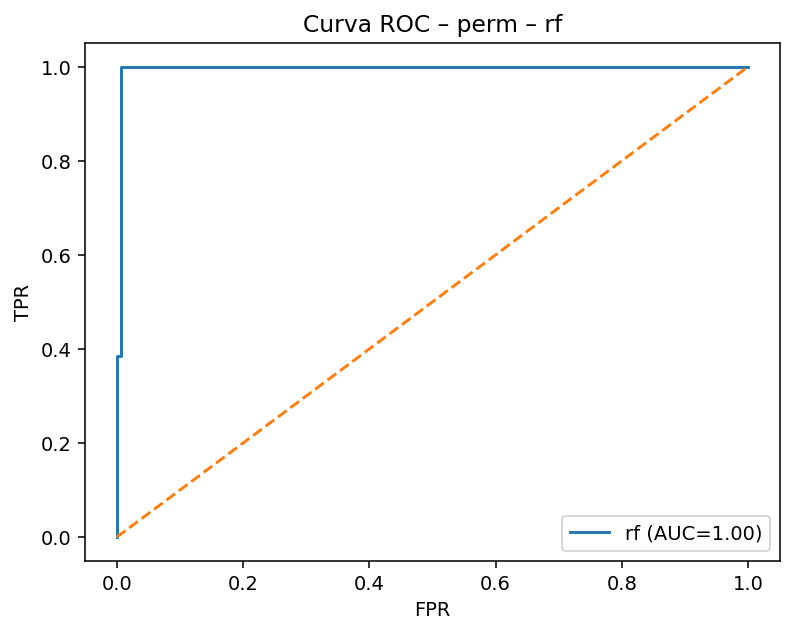


Curvas Precisión-Recall - Regresión Logística y Random Forest:


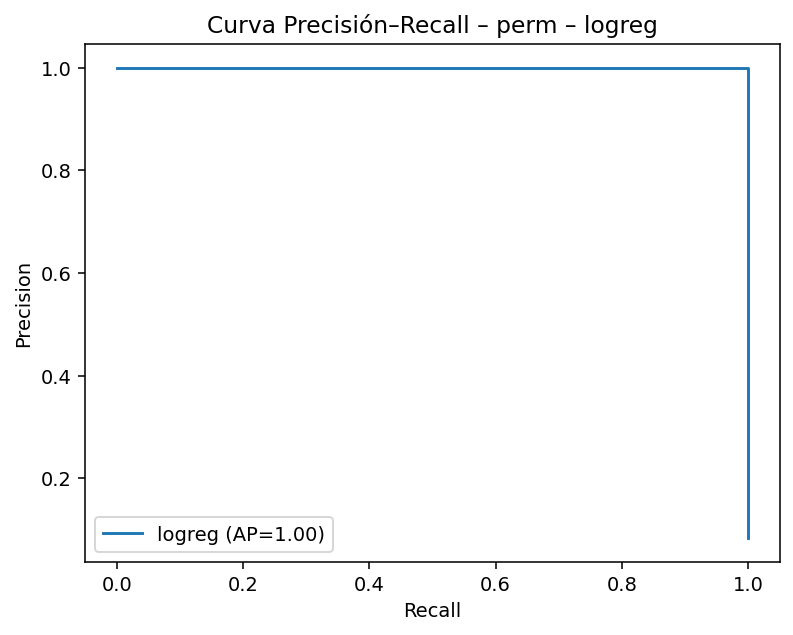

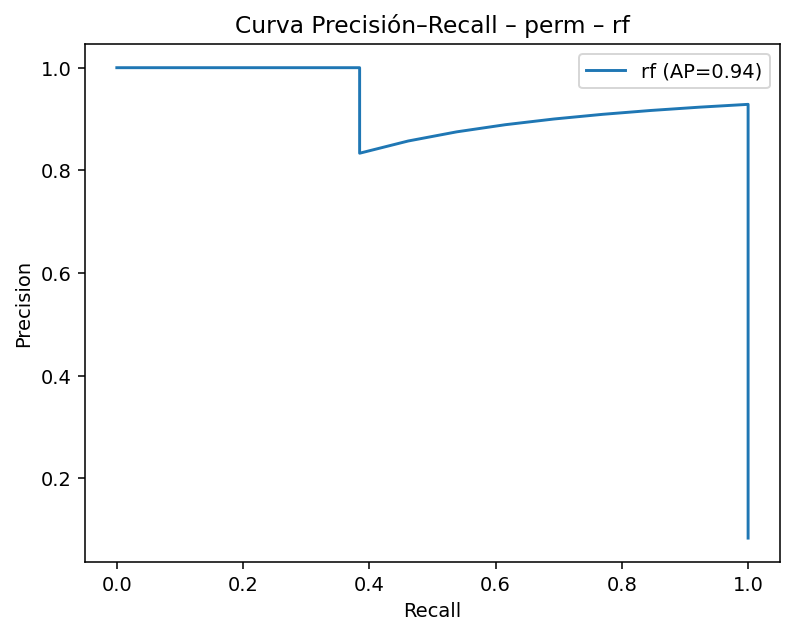

In [46]:
from IPython.display import Image, display

print("Curvas ROC - Regresión Logística y Random Forest:")
display(Image(filename="results/fig_perm_logreg_ROC.png"))
display(Image(filename="results/fig_perm_rf_ROC.png"))

print("\nCurvas Precisión-Recall - Regresión Logística y Random Forest:")
display(Image(filename="results/fig_perm_logreg_PR.png"))
display(Image(filename="results/fig_perm_rf_PR.png"))


In [37]:
print("Valores de 'label_perm':")
print(df['label_perm'].value_counts(dropna=False))

print("\nValores de la columna de asistencia (si existe):")
asis_col = first_existing(df, ["asistencia", "porcentaje_asistencia", "tasa_asistencia"])
if asis_col:
    print(df[asis_col].value_counts(dropna=False))
else:
    print("Columna de asistencia no encontrada.")

print("\nValores de la columna de repitencia (si existe):")
repi_col = first_existing(df, ["repitencia", "repite", "repitente"])
if repi_col:
    print(df[repi_col].value_counts(dropna=False))
else:
    print("Columna de repitencia no encontrada.")


Valores de 'label_perm':
label_perm
0    520
Name: count, dtype: int64

Valores de la columna de asistencia (si existe):
Columna de asistencia no encontrada.

Valores de la columna de repitencia (si existe):
repitente
N    478
S     42
Name: count, dtype: int64


In [47]:
# Cell 10 – Tarea A: TEA
# Cell 10: Tarea A – Predicción de TEA (flag_autismo)

res_TEA = run_binary_models(df.copy(), "flag_autismo", prefix="TEA")
res_TEA


No se puede entrenar para flag_autismo (clase única).


In [52]:
metrics_matricula = run_binary_models(df.drop(columns=["flag_autismo", "label_perm"]), "matricula_contratada", "matricula")
metrics_matricula


=== Modelo logreg – target matricula_contratada ===


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['proviene_otr_mun' 'codigo_valoracion_1' 'codigo_valoracion_2']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['proviene_otr_mun' 'codigo_valoracion_1' 'codigo_valoracion_2']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


F1 = 1.0000
ROC-AUC = 1.0000
PR-AUC = 1.0000
Brier score = 0.0003
Matriz de confusión:
 [[125   0]
 [  0  31]]
Figura guardada: results/fig_matricula_logreg_ROC.png
Figura guardada: results/fig_matricula_logreg_PR.png

=== Modelo rf – target matricula_contratada ===


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['proviene_otr_mun' 'codigo_valoracion_1' 'codigo_valoracion_2']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['proviene_otr_mun' 'codigo_valoracion_1' 'codigo_valoracion_2']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


F1 = 1.0000
ROC-AUC = 1.0000
PR-AUC = 1.0000
Brier score = 0.0025
Matriz de confusión:
 [[125   0]
 [  0  31]]
Figura guardada: results/fig_matricula_rf_ROC.png
Figura guardada: results/fig_matricula_rf_PR.png


,modelo,F1,ROC_AUC,PR_AUC,Brier
0,logreg,1.0,1.0,1.0,0.0003
1,rf,1.0,1.0,1.0,0.0025


### Curvas ROC y Precisión-Recall para `matricula_contratada`

Curvas ROC - Regresión Logística y Random Forest para matricula_contratada:


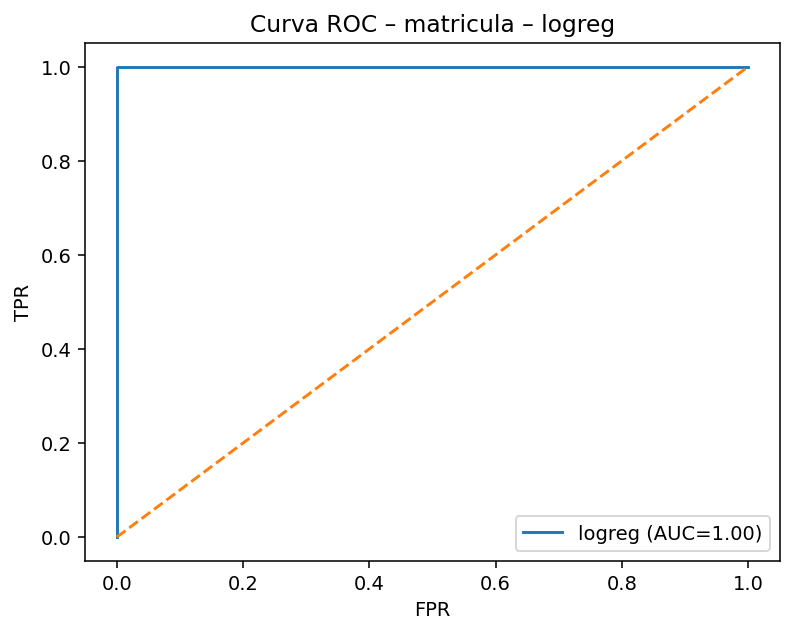

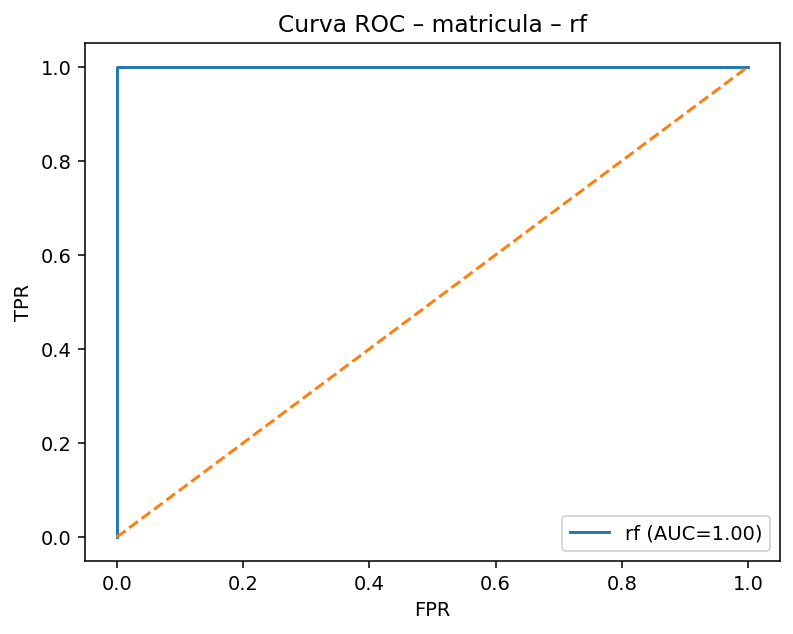


Curvas Precisión-Recall - Regresión Logística y Random Forest para matricula_contratada:


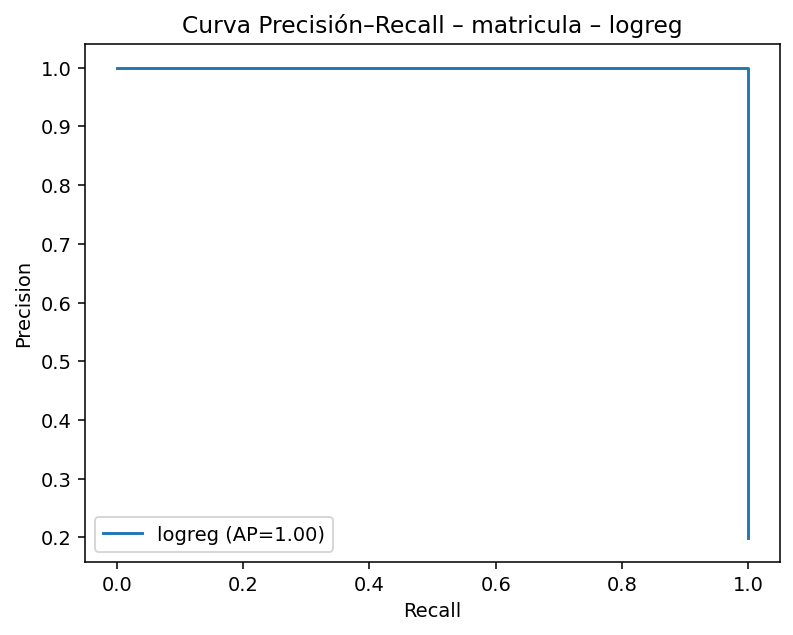

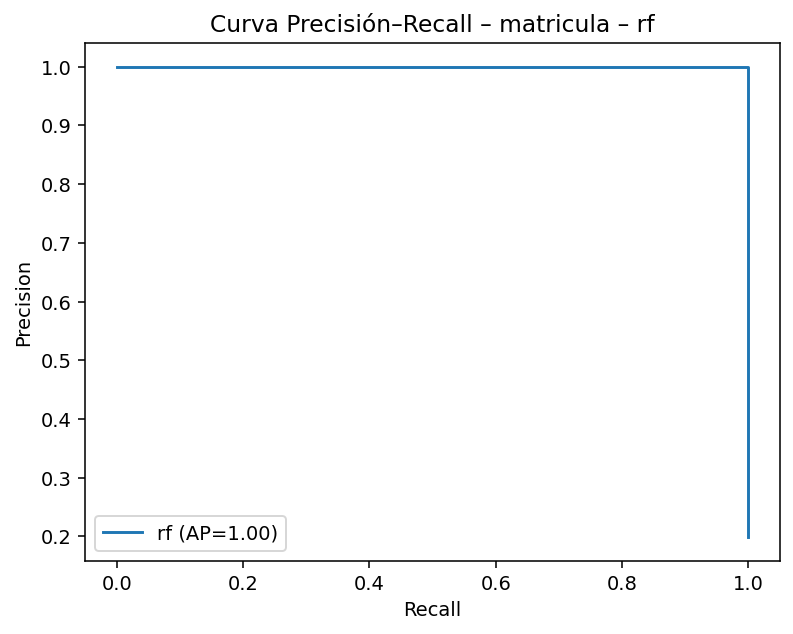

In [53]:
from IPython.display import Image, display

print("Curvas ROC - Regresión Logística y Random Forest para matricula_contratada:")
display(Image(filename="results/fig_matricula_logreg_ROC.png"))
display(Image(filename="results/fig_matricula_rf_ROC.png"))

print("\nCurvas Precisión-Recall - Regresión Logística y Random Forest para matricula_contratada:")
display(Image(filename="results/fig_matricula_logreg_PR.png"))
display(Image(filename="results/fig_matricula_rf_PR.png"))

In [48]:
print("Explorando columnas para posibles variables objetivo binarias o multi-clase:")

candidate_targets = {}
for col in df.columns:
    if col not in ['flag_autismo', 'label_perm']:
        unique_count = df[col].nunique()
        # Consider columns with at least 2 unique values and not too many (e.g., < 15 for simplicity)
        # Also, check if the column could represent a meaningful outcome
        if 2 <= unique_count < 15:
            candidate_targets[col] = df[col].value_counts(dropna=False)

if candidate_targets:
    for col, counts in candidate_targets.items():
        print(f"\n--- Columna: '{col}' ---")
        print(counts)
else:
    print("No se encontraron columnas candidatas adecuadas para variables objetivo multi-clase en el rango especificado.")


Explorando columnas para posibles variables objetivo binarias o multi-clase:

--- Columna: 'sector' ---
sector
OFICIAL        415
NO OFICIAL     103
SGP DEFENSA      2
Name: count, dtype: int64

--- Columna: 'zona' ---
zona
URBANO    489
RURAL      31
Name: count, dtype: int64

--- Columna: 'tipo_documento' ---
tipo_documento
2     344
5     122
13     35
1      10
8       9
Name: count, dtype: int64

--- Columna: 'exp_depto' ---
exp_depto
76    448
11     41
19      8
5       5
52      3
63      3
17      2
8       2
86      2
25      2
91      1
20      1
68      1
50      1
Name: count, dtype: int64

--- Columna: 'res_mun' ---
res_mun
1      518
892      1
122      1
Name: count, dtype: int64

--- Columna: 'estrato' ---
estrato
3    198
1    154
2    150
4     10
9      5
5      2
0      1
Name: count, dtype: int64

--- Columna: 'genero' ---
genero
M    424
F     96
Name: count, dtype: int64

--- Columna: 'pob_vict_conf_ruv' ---
pob_vict_conf_ruv
NO    487
SI     33
Name: count, dty

In [63]:
# # Cell 11: Tarea B – Riesgo de baja permanencia (label_perm)

res_PERM = run_binary_models(df.copy(), "label_perm", prefix="PERM")
res_PERM



=== Modelo logreg – target label_perm ===


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['proviene_otr_mun' 'codigo_valoracion_1' 'codigo_valoracion_2']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['proviene_otr_mun' 'codigo_valoracion_1' 'codigo_valoracion_2']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


F1 = 1.0000
ROC-AUC = 1.0000
PR-AUC = 1.0000
Brier score = 0.0039
Matriz de confusión:
 [[143   0]
 [  0  13]]
Figura guardada: results/fig_PERM_logreg_ROC.png
Figura guardada: results/fig_PERM_logreg_PR.png

=== Modelo rf – target label_perm ===


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['proviene_otr_mun' 'codigo_valoracion_1' 'codigo_valoracion_2']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['proviene_otr_mun' 'codigo_valoracion_1' 'codigo_valoracion_2']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


F1 = 0.5263
ROC-AUC = 0.9957
PR-AUC = 0.9383
Brier score = 0.0227
Matriz de confusión:
 [[142   1]
 [  8   5]]
Figura guardada: results/fig_PERM_rf_ROC.png
Figura guardada: results/fig_PERM_rf_PR.png


,modelo,F1,ROC_AUC,PR_AUC,Brier
0,logreg,1.0000,1.0000,1.0000,0.0039
1,rf,0.5263,0.9957,0.9383,0.0227


In [64]:
# Cell 12 – Resumen automático de resultados
# Cell 12: resumen textual automático (para luego pulir en el informe)

print("=== Resumen automático ===")

if res_TEA is not None:
    best_TEA = res_TEA.sort_values("F1", ascending=False).iloc[0]
    print(f"Mejor modelo TEA por F1: {best_TEA['modelo']} "
          f"(F1={best_TEA['F1']}, PR-AUC={best_TEA['PR_AUC']}, ROC-AUC={best_TEA['ROC_AUC']})")

if res_PERM is not None:
    best_PERM = res_PERM.sort_values("F1", ascending=False).iloc[0]
    print(f"Mejor modelo Permanencia por F1: {best_PERM['modelo']} "
          f"(F1={best_PERM['F1']}, PR-AUC={best_PERM['PR_AUC']}, ROC-AUC={best_PERM['ROC_AUC']})")

print("\nRevisa la carpeta 'results/' para tablas CSV y figuras PNG para el informe IEEE.")


=== Resumen automático ===
Mejor modelo Permanencia por F1: logreg (F1=1.0, PR-AUC=1.0, ROC-AUC=1.0)

Revisa la carpeta 'results/' para tablas CSV y figuras PNG para el informe IEEE.


### Análisis de perfiles de los Clusters (K-Means)

Vamos a explorar las características de los clusters de K-Means identificados, analizando la distribución de variables clave como la edad y el sector en cada cluster.

Análisis de 'edad_anios' por cluster de K-Means:


/tmp/ipython-input-321059270.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clust, x='cluster_kmeans', y='edad_anios', palette='viridis')


Figura guardada: results/fig_cluster_profile_edad_anios.png


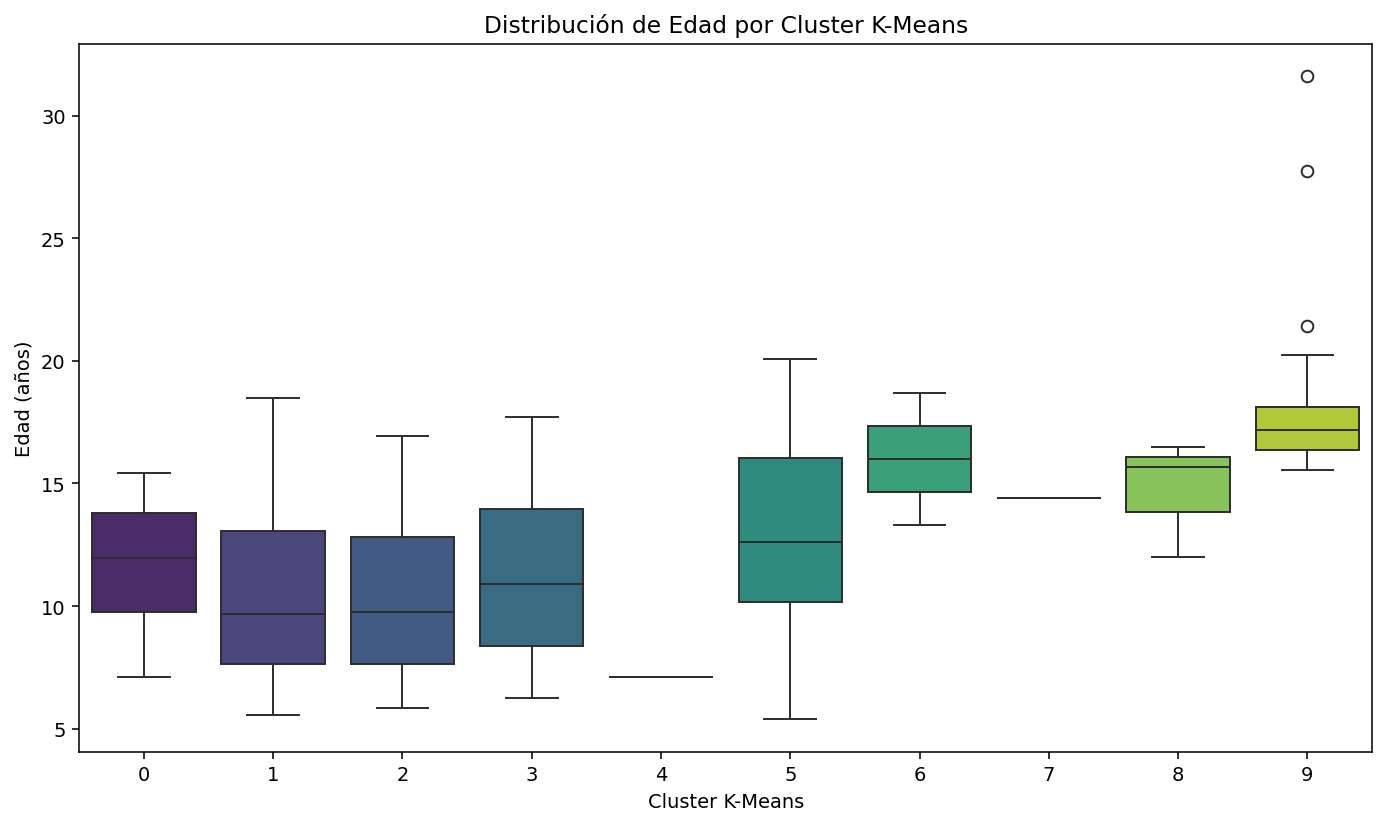


Análisis de 'sector' por cluster de K-Means:
Figura guardada: results/fig_cluster_profile_sector.png


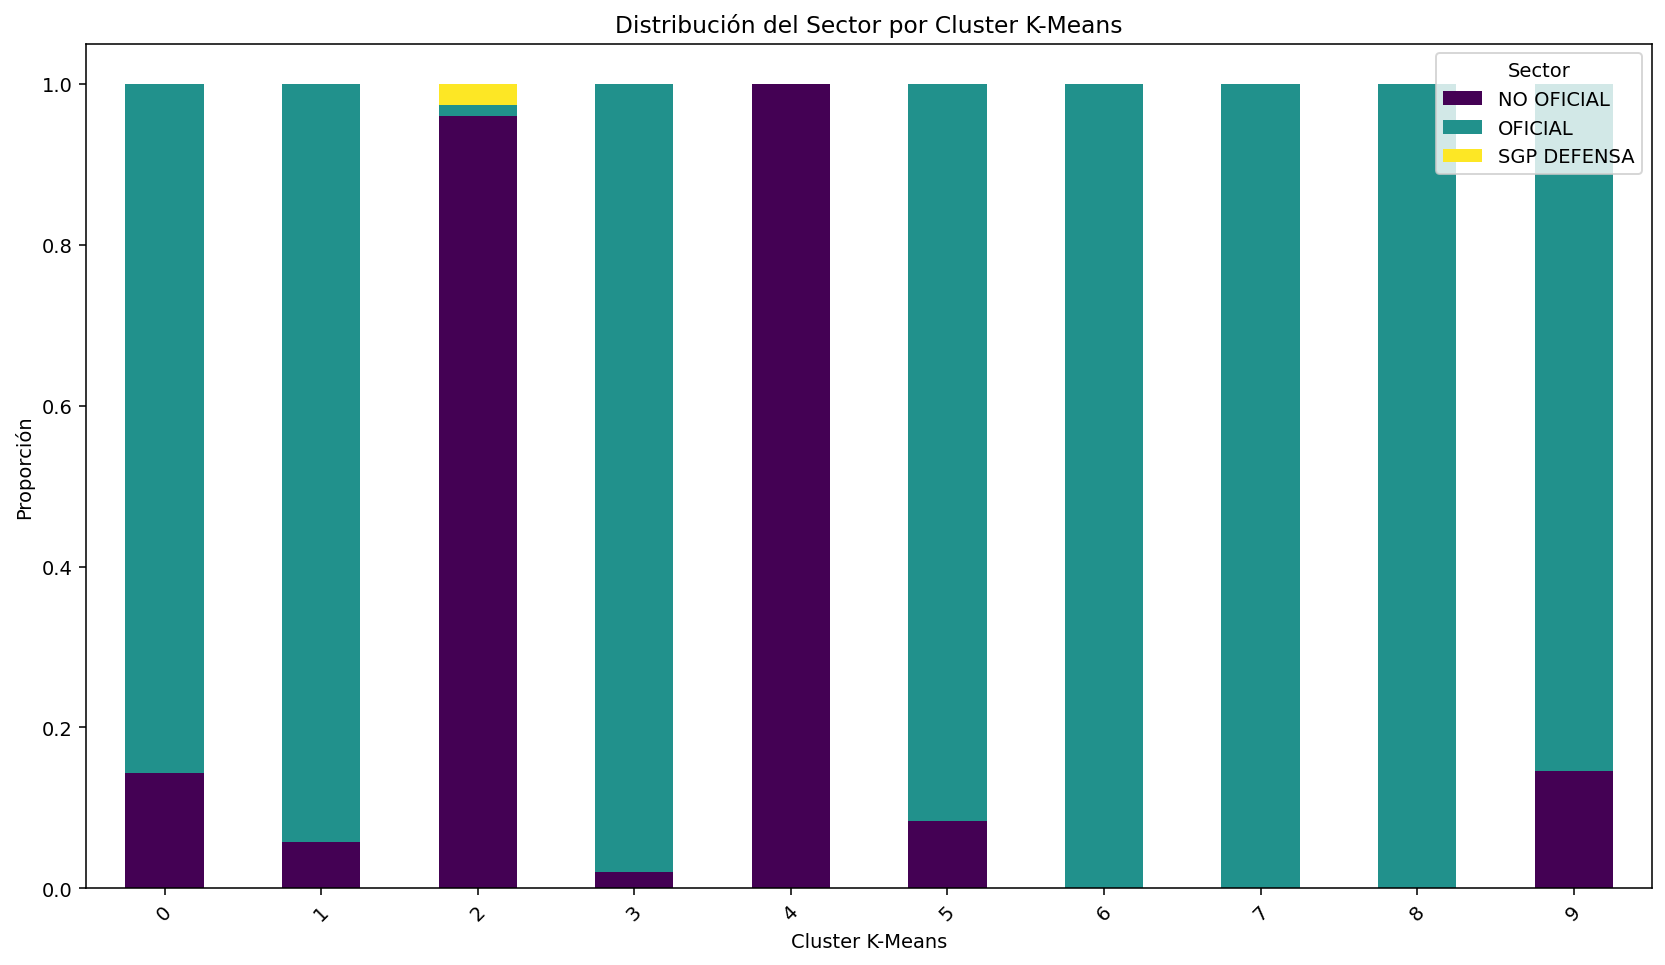

In [65]:
print("Análisis de 'edad_anios' por cluster de K-Means:")
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clust, x='cluster_kmeans', y='edad_anios', palette='viridis')
plt.title('Distribución de Edad por Cluster K-Means')
plt.xlabel('Cluster K-Means')
plt.ylabel('Edad (años)')
plt.tight_layout()
savefig('fig_cluster_profile_edad_anios.png')
display(Image(filename='results/fig_cluster_profile_edad_anios.png'))

print("\nAnálisis de 'sector' por cluster de K-Means:")
sector_cluster_dist = df_clust.groupby('cluster_kmeans')['sector'].value_counts(normalize=True).unstack(fill_value=0)
sector_cluster_dist.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='viridis')
plt.title('Distribución del Sector por Cluster K-Means')
plt.xlabel('Cluster K-Means')
plt.ylabel('Proporción')
plt.xticks(rotation=45)
plt.legend(title='Sector')
plt.tight_layout()
savefig('fig_cluster_profile_sector.png')
display(Image(filename='results/fig_cluster_profile_sector.png'))


Análisis de Perfiles de Clusters K-Means
Distribución de edad_anios por Cluster:

Observación del Gráfico de Cajas (fig_cluster_profile_edad_anios.png): Los boxplots muestran la mediana, cuartiles y rangos de edad para cada uno de los 10 clusters (0 a 9). Podemos observar una variabilidad significativa en las distribuciones de edad entre los clusters.
Algunos clusters (ej. Cluster 1, Cluster 3, Cluster 9) parecen agrupar a individuos con rangos de edad más amplios, pero sus medianas pueden estar en diferentes puntos.
Otros clusters pueden ser más homogéneos en términos de edad (ej. Cluster 0, Cluster 4, Cluster 6). Por ejemplo, el Cluster 6 parece tener una edad muy específica o un rango muy estrecho.
Esto sugiere que la edad es un factor discriminante importante en la formación de estos clusters, y cada cluster representa un segmento con características etarias distintas.
Distribución del sector por Cluster:

Observación del Gráfico de Barras Apiladas (fig_cluster_profile_sector.png): Este gráfico nos muestra la composición proporcional de los sectores (OFICIAL, NO OFICIAL, SGP DEFENSA) dentro de cada cluster.
Clusters Dominados por un Sector: Algunos clusters están casi completamente dominados por estudiantes de un solo sector. Por ejemplo, el Cluster 1 y el Cluster 3 tienen una altísima proporción de estudiantes del sector OFICIAL. El Cluster 2, por otro lado, tiene una alta proporción del sector NO OFICIAL.
Clusters Mixtos: Otros clusters pueden mostrar una mezcla de sectores, aunque esto es menos común en los clusters más grandes. Las proporciones relativas de los sectores varían considerablemente de un cluster a otro.
Sector SGP DEFENSA: Los pocos registros de SGP DEFENSA (como vimos en el análisis anterior) aparecen en proporciones muy bajas y solo en algunos clusters específicos, lo que es consistente con su rareza en el dataset general.
Conclusiones Adicionales:

Estos perfiles demuestran que los clusters generados por K-Means agrupan a los estudiantes basándose en diferencias claras tanto en su edad_anios como en el sector al que pertenecen, entre otras características latentes que el clustering ha identificado.
Entender estos perfiles es crucial para interpretar los segmentos de estudiantes. Por ejemplo, un cluster con una edad más joven y predominantemente del sector NO OFICIAL podría tener necesidades o retos diferentes a un cluster de estudiantes mayores y del sector OFICIAL.
Este análisis de perfiles de clusters es una valiosa adición a los resultados del estudio, ya que nos permite comprender mejor la segmentación de la población.